Importing Required Packages

In [1]:
import glob
import cv2
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import random
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
import keras

Installing Keras OCR package. This package is one of the widely used python packages for character recognition

In [2]:
!pip install keras_ocr
import keras_ocr

Since I am using Google Colab, I uploaded the files using files package. This part can be commented if python is installed in the local drive

In [3]:
from google.colab import files

In [8]:
uploaded = files.upload()

Read all the uploaded files using keras image read tool. Images are read in a form of 3 dimensional arrays which are stored in a list

In [4]:
pipeline = keras_ocr.pipeline.Pipeline()

# Get a set of three example images
images = [
    keras_ocr.tools.read(file) for file in glob.glob('*.jpg')
]


Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


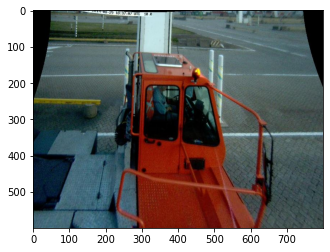

In [5]:
len(images)
pyplot.imshow(images[2])
pyplot.show()

In [6]:
images_class = images
#print(images[0])
#for im_show in images_class:
#  pyplot.imshow(im_show)
#  pyplot.show()
# show the figure
# pyplot.show()

I hard coded the labels of the images (1='Container',0='Not a Container') to train classification model.

In [7]:
labels = [1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1]

Since the size of the data is very small (only 37 images), I used 4 data Augmentation techniques - Horizontal Shift, Vertical Shift, Brightness Change and Zoom in Zoom out to increase the number of samples. After this step, total sample size increased to 37*9*4 = 1,332 images!

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


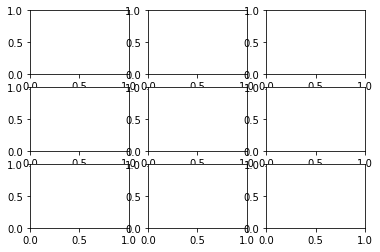

In [8]:
from numpy import expand_dims
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
#img = load_img('Veh_4160_Seg_7_Cam_3.jpg')
# convert to numpy array
img_list = []
label_list = []
label_it = 0
for img in  images_class:
  # data = img_to_array(img)
  # expand dimension to one sample
  samples = expand_dims(img, 0)
  # create image data augmentation generator
  datagen = ImageDataGenerator(width_shift_range=[-200,200])
  datagen1 = ImageDataGenerator(height_shift_range=0.5)
  datagen2 = ImageDataGenerator(brightness_range=[0.2,1.0])
  datagen3 = ImageDataGenerator(zoom_range=[0.5,1.0])
  # prepare iterator
  it = datagen.flow(samples, batch_size=1)
  it1 = datagen1.flow(samples, batch_size=1)
  it2 = datagen2.flow(samples, batch_size=1)
  it3 = datagen3.flow(samples, batch_size=1)
  # generate samples and plot
  for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    batch1 = it1.next()
    batch2 = it2.next()
    batch3 = it3.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    image1 = batch1[0].astype('uint8')
    image2 = batch2[0].astype('uint8')
    image3 = batch3[0].astype('uint8')
    # plot raw pixel data
    img_list.append(image)
    img_list.append(image1)
    img_list.append(image2)
    img_list.append(image3)
    label_list.append(labels[label_it])
    label_list.append(labels[label_it])
    label_list.append(labels[label_it])
    label_list.append(labels[label_it])
    #plt.imshow(image)
  label_it=label_it+1
# show the figure
#pyplot.show()


0


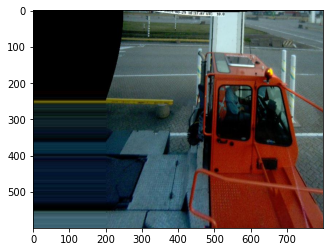

In [76]:
pyplot.imshow(img_list[72])
print(label_list[72])


Shuffle the image data for random re distribution before train, test split.

In [9]:
image_list_merged = list(zip(img_list, label_list))

random.shuffle(image_list_merged)

img_list_rnd, label_list_rnd = list(zip(*image_list_merged))
img_list_rnd = list(img_list_rnd)
label_list_rnd = list(label_list_rnd)

1
1332
79


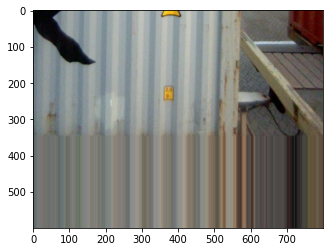

In [77]:
pyplot.imshow(img_list_rnd[0])
print(label_list_rnd[0])
print(len(label_list_rnd))
print(label_list_rnd.index(0))

Split the data into train, test and validation

In [11]:
x_train,x_val,x_test,y_train,y_val,y_test = img_list_rnd[:700],img_list_rnd[701:999],img_list_rnd[1000:],label_list_rnd[:700],label_list_rnd[701:999],label_list_rnd[1000:]
print(len(x_train),len(x_test))

700 332


For Image classification, since the data volume is still low, I applied transfer learning and used a pretrained CNN model Xception.
This model excepts image tensors of 224X224 size 

In [13]:
resized_x_train = tf.image.resize(x_train,[224,224])
resized_x_val = tf.image.resize(x_val,[224,224])
resized_x_test = tf.image.resize(x_test,[224,224])

In [14]:
resized_x_train1 = keras.applications.xception.preprocess_input(resized_x_train)
resized_x_val1 = keras.applications.xception.preprocess_input(resized_x_val)
resized_x_test1 = keras.applications.xception.preprocess_input(resized_x_test)
#train_set = (resized_image_list,y_train).batch(32).prefetch(1)

Define two more top layers on pretrained model base

In [17]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(2,activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

In [20]:
for layer in base_model.layers:
  layer.trainable = False

In [32]:
y_train1 = np.array(y_train)
y_val1 = np.array(y_val)
y_test1 = np.array(y_test)

After 2 Epochs, Model validation accuracy obtained a score of 1. In real world, such a high accuracy is rare. Since in our sample, there were only 2 negative images, Model was probably overfitted. We can use more image variations of negative images to prevent over fitting. However, for our case, I used the below trained model.

In [29]:
optimizer = keras.optimizers.SGD(lr=0.2,momentum=0.9,decay=0.01)
model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
history = model.fit(x=resized_x_train1, y=y_train1, epochs=5, validation_data=(resized_x_val1,y_val1))

Epoch 1/5
22/22 [==============================] - 211s 10s/step - loss: 0.3034 - accuracy: 0.9742 - val_loss: 0.0785 - val_accuracy: 0.9866
Epoch 2/5
22/22 [==============================] - 211s 10s/step - loss: 0.0069 - accuracy: 0.9949 - val_loss: 4.0003e-10 - val_accuracy: 1.0000
Epoch 3/5
22/22 [==============================] - 211s 10s/step - loss: 4.3329e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
22/22 [==============================] - 208s 10s/step - loss: 2.4664e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
22/22 [==============================] - 203s 9s/step - loss: 7.2129e-10 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [31]:
y_pred = model.predict(resized_x_test1)

In [60]:
y_pred1 = y_pred[:,1]
y_pred_int = y_pred1.astype(int)

print(y_pred_int.dtype)

int64


In [61]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test1,y_pred_int)

array([[ 19,   0],
       [  1, 312]])

In [78]:
from sklearn.metrics import f1_score
f1_score(y_test1,y_pred_int)

0.9984

In [62]:
#prediction_groups = []
#for image in images:
#    predictions = pipeline.recognize([image])
#    prediction_groups.append(predictions)

Below function prints "Not a container image" if image is not a container. If its a container image, Function prints characters in the image

In [74]:
#test_image = keras_ocr.tools.read('Veh_4166_Seg_8_Cam_3.jpg')

def ocr(img):
  resized_img = tf.image.resize(img,[224,224])
  resized_img1 = keras.applications.xception.preprocess_input(resized_img)
  pred = model.predict(resized_img1)
  pred1 = pred[:,1]
  pred2 = pred1.astype(int)
  if pred2 == 0:
    print("Not a container image")
    pyplot.imshow(img[0])
    pyplot.show()
  else:
    prediction_groups = []
    for image in img:
      predictions = pipeline.recognize([image])
      prediction_groups.append(predictions) 
    fig, axs = plt.subplots(nrows=len(img), figsize=(20, 20))
    i = 0
    for pred in prediction_groups:
      for  image, predictions in zip( img, pred):
        keras_ocr.tools.drawAnnotations(image=img[i], predictions=predictions, ax=None) 
        i = i+1



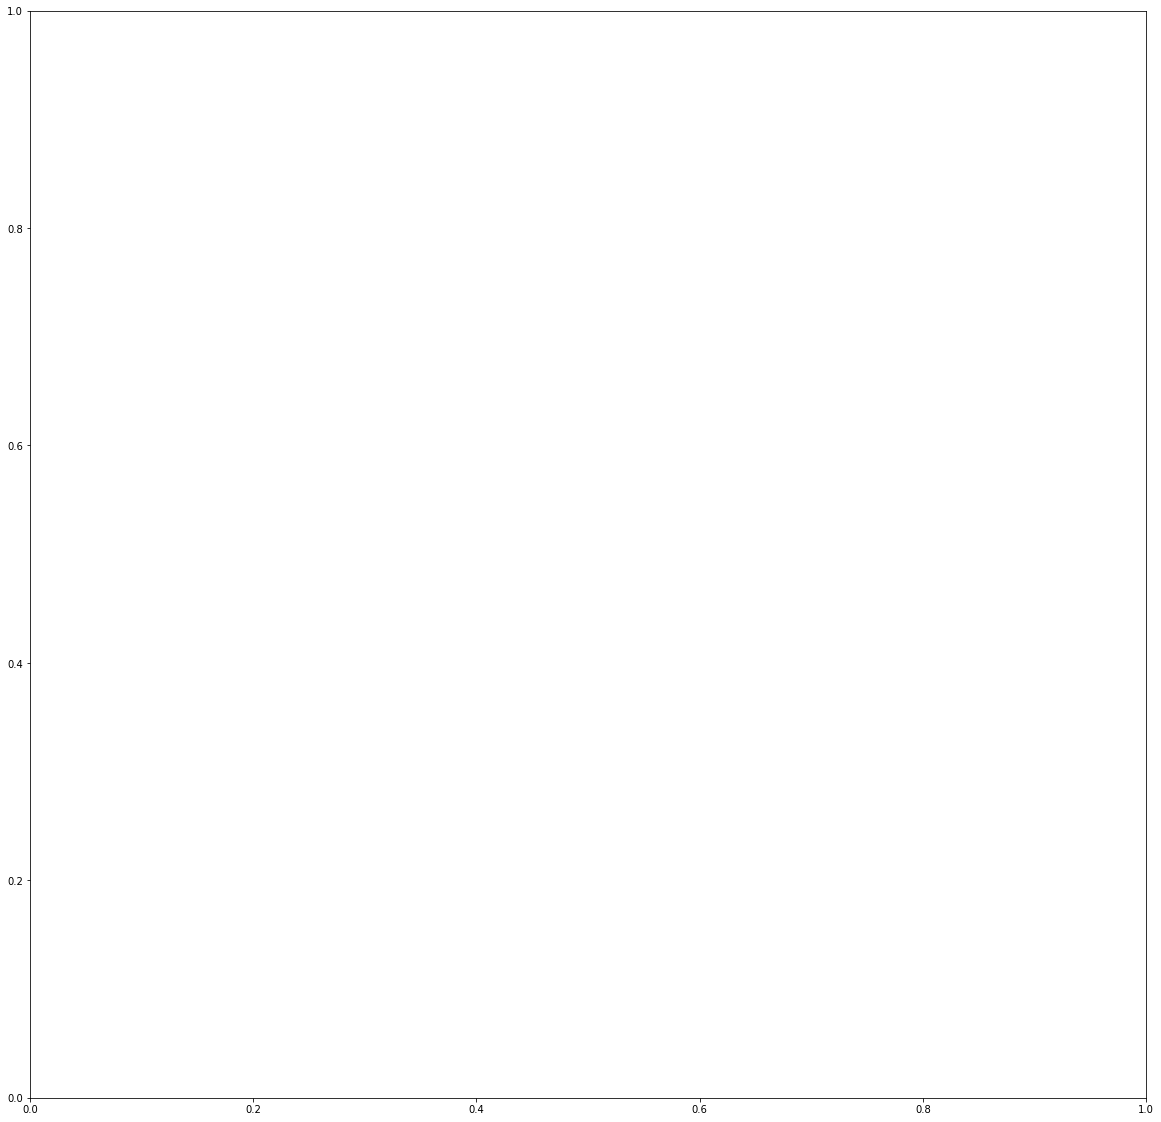

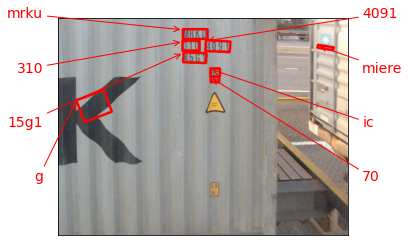

In [73]:
test_image = [
    keras_ocr.tools.read(file) for file in glob.glob('Veh_4161_Seg_2_Cam_2.jpg')
]
ocr(test_image)

Not a container image


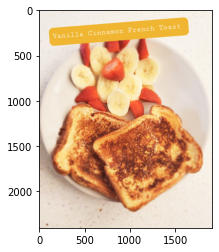

In [75]:
test_image = [
    keras_ocr.tools.read(file) for file in glob.glob('20201222_195435.jpg')
]
ocr(test_image)

In [ ]:
# Plot the predictions
# fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
# i = 0
# for pred in prediction_groups:
#    for  image, predictions in zip( images, pred):
#        keras_ocr.tools.drawAnnotations(image=images[i], predictions=predictions, ax=None) 
#        i = i+1